In [13]:
import torch
import torch.distributions.constraints
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
torch.TORCH_SAFE_GLOBALS = True

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

In noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


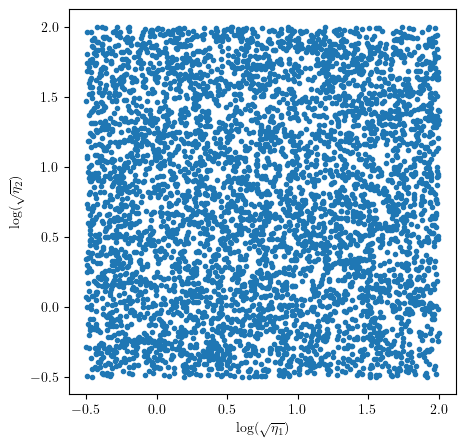

In [14]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type="in_noise", d_condition="<=", noise = 0.5, num_samples=1)

etas_test, gs_test = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Datasets

In [15]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32).to(device)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32).to(device)

## Training Parameters

In [16]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "num_layers": 4,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 1.], device=device, dtype=torch.float32),
    "device": device,
    "output_prior_conc_rate": torch.tensor([0.5, 1.0], device=device, dtype=torch.float32),
    "noise" : "heteroscedastic"
}

chkpt_dir = "../Model_Checkpoints/SVI/Aleatoric_Hetero_5k/"
data_dir = "Aleatoric_Hetero_5k/"
chkpt_prefix = "Regular_Aleatoric_5k"

In [17]:
model = TurbulenceNetworkBayesian(**model_params).to(device)

display(model)

guide = AutoMultivariateNormal(model)

adam = Adam({"lr": 0.0015})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=40))


TurbulenceNetworkBayesian(
  (layers): PyroModuleList(
    (0): PyroLinear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): PyroLinear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): PyroLinear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): PyroLinear(in_features=20, out_features=6, bias=True)
  )
)

## SVI Training

In [18]:
pyro.clear_param_store()

n_epochs = 1500

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        with torch.no_grad():
            test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:20.4f}, Train loss: {loss:20.4f}")

Epoch        0 Test loss:           63521.8386, Train loss:          259779.7999
Epoch        5 Test loss:           35221.7780, Train loss:          211679.3210
Epoch       10 Test loss:           23464.3760, Train loss:          151712.6481
Epoch       15 Test loss:           19300.7556, Train loss:          117139.3717
Epoch       20 Test loss:           18740.3910, Train loss:          104025.7734
Epoch       25 Test loss:           21661.0445, Train loss:           79139.2057
Epoch       30 Test loss:           19385.5986, Train loss:           52382.3210
Epoch       35 Test loss:           15842.5077, Train loss:           21677.4682
Epoch       40 Test loss:           14573.7859, Train loss:           -1209.0770
Epoch       45 Test loss:           11876.1369, Train loss:          -19844.2965
Epoch       50 Test loss:            7481.7772, Train loss:          -42485.3270
Epoch       55 Test loss:            9344.5883, Train loss:          -61057.3686
Epoch       60 Test loss:   

KeyboardInterrupt: 

In [20]:
save_pyro_model(model, guide, chkpt_dir, chkpt_name=chkpt_prefix + '_SVI1')

## Loading Trained Model

In [8]:
torch.cuda.empty_cache()
pyro.clear_param_store()
model = TurbulenceNetworkBayesian(**model_params)

model, guide = load_pyro_model(model, chkpt_dir, device, chkpt_name=chkpt_prefix+'_SVI1')

model = model.to(device)
guide = guide.to(device)

MAE:  0.0084618379606123


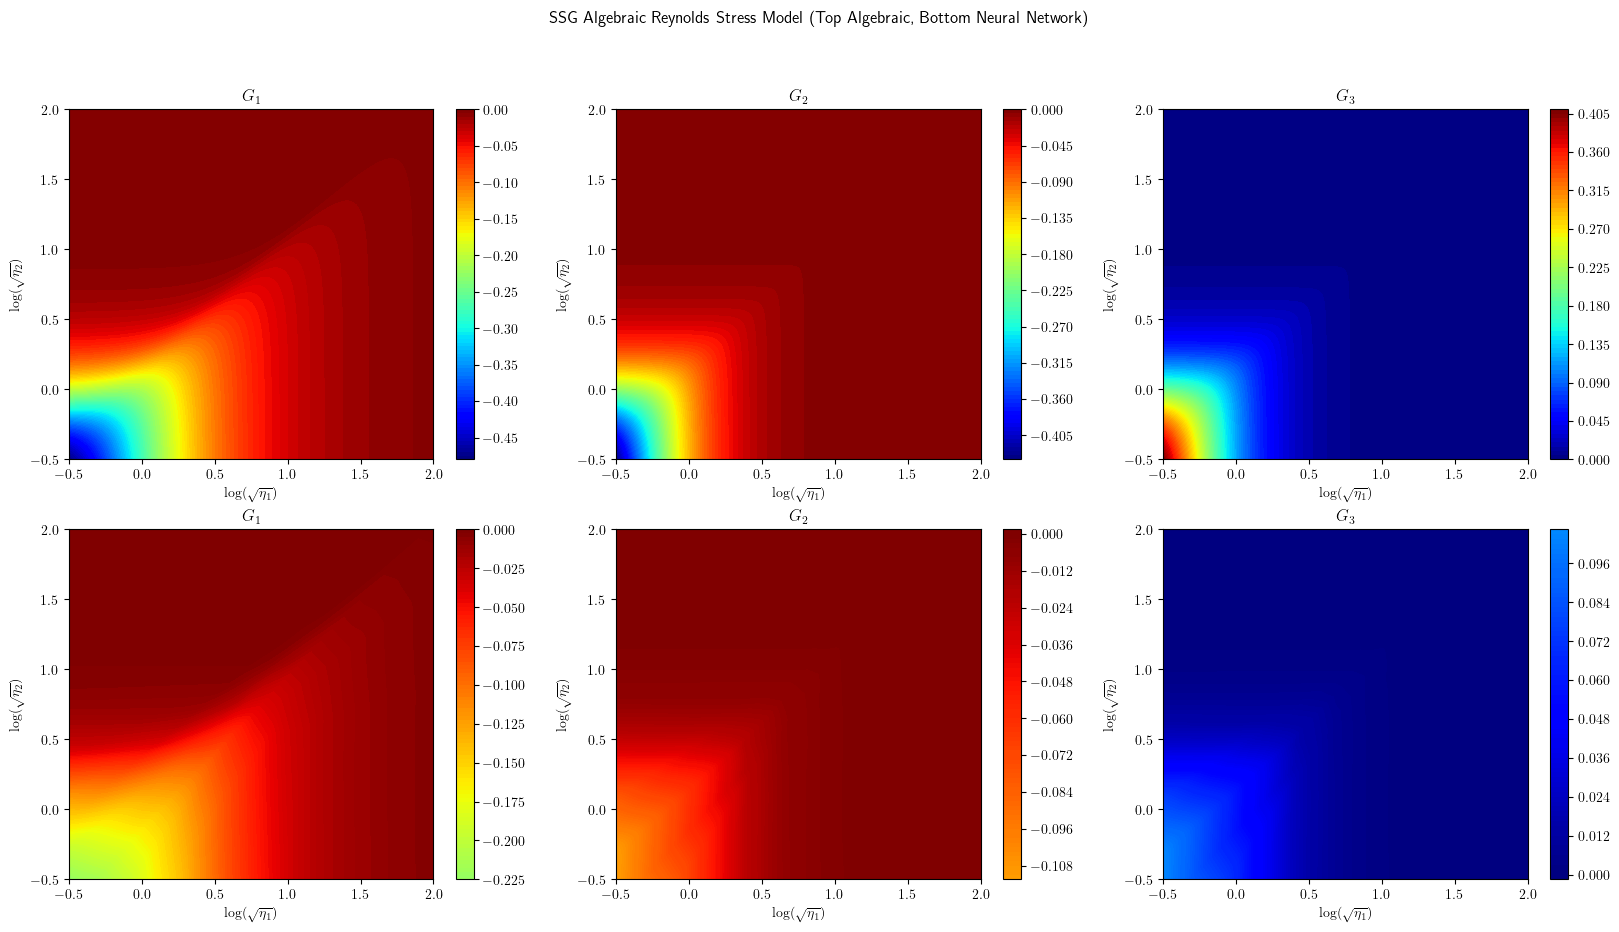

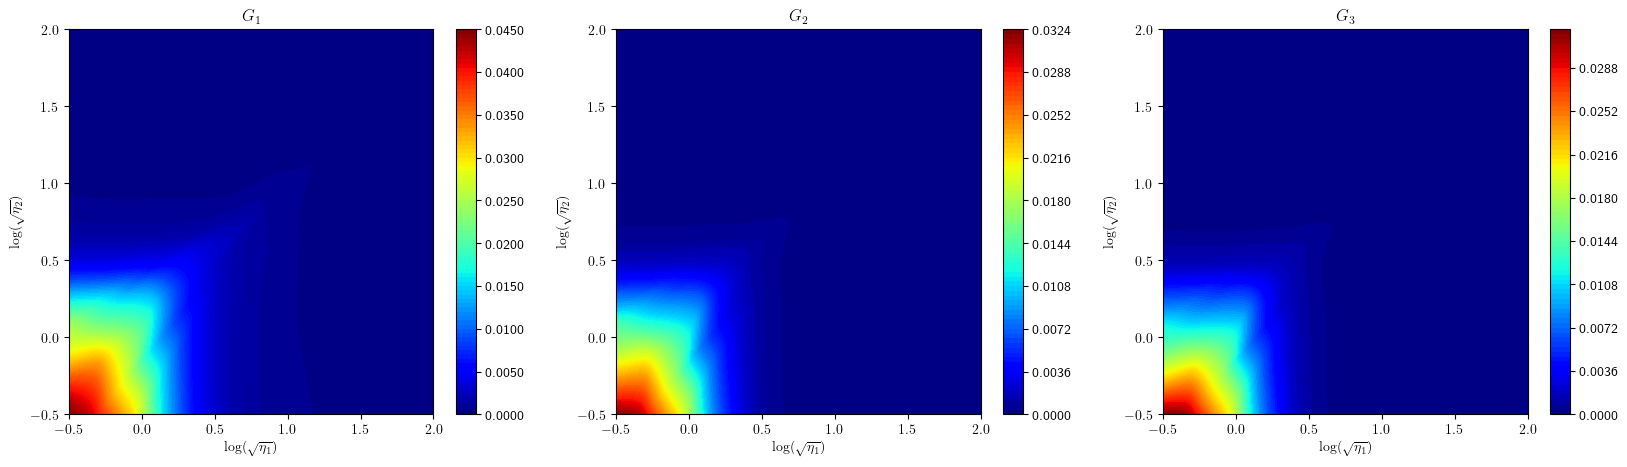

In [21]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

sites = ["_RETURN", "sigma"] if model_params['noise'] == "homoscedastic" else ["_RETURN"]
test_etas = torch.tensor(etas, dtype=torch.float32).to(device)

prediction_dict = batch_predictive(model, guide, test_etas, total=200, batch_size=50, sites=sites)

if model_params['noise'] == "homoscedastic":
    pred = prediction_dict["_RETURN"]
    sig_samples = prediction_dict["sigma"]
    sig_mean = np.mean(sig_samples, axis=0) * y_scaler.scale_
elif model_params['noise'] == "heteroscedastic":
    pred = prediction_dict["_RETURN"][:, :, :3]
    sig_samples = np.exp(prediction_dict["_RETURN"][:, :, 3:])
    sig_mean = np.sqrt(np.mean(sig_samples, axis=0) * y_scaler.scale_**2)
else:
    pred = prediction_dict["_RETURN"]

for i in range(pred.shape[0]):
    pred[i] = y_scaler.inverse_transform(pred[i])

pred_mean = np.mean(pred, axis=0)
pred_std = np.std(pred, axis=0)

if model_params['noise'] == "heteroscedastic" or model_params['noise'] == "heteroscedastic":
    pred_std = np.sqrt(pred_std**2 + sig_mean**2)
    np.savetxt('../data/SVI/' + data_dir + chkpt_prefix + '_Obs_Noise.csv', sig_mean, delimiter=',')

np.savetxt('../data/SVI/' + data_dir + chkpt_prefix + '_Pred_Mean.csv', pred_mean, delimiter=',')
np.savetxt('../data/SVI/' + data_dir + chkpt_prefix + '_Pred_Std.csv', pred_std, delimiter=',')

torch.cuda.empty_cache()

print("MAE: ", np.mean(np.abs(pred_mean - target)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

/tmp/ipykernel_152876/905180805.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_heat_map_3D(x_grid, y_grid, torch.abs(torch.tensor(target) - pred_mean).T.reshape(3, dim, dim) / pred_std.T.reshape(3, dim, dim))


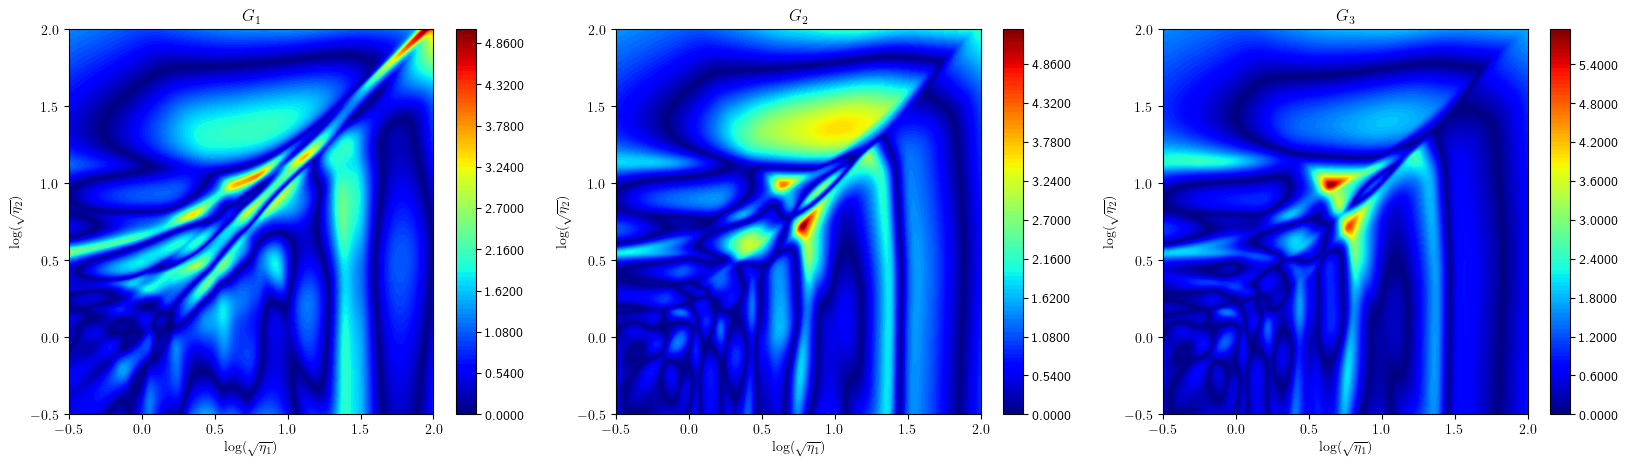

In [21]:
plot_heat_map_3D(x_grid, y_grid, torch.abs(torch.tensor(target) - pred_mean).T.reshape(3, dim, dim) / pred_std.T.reshape(3, dim, dim))

Obs Noise: [[0.00078664 0.00036835 0.00034397]]
Mean as Prediction
Mean of (mean - y): [-1.69515428e-04 -4.01777006e-05  2.91627097e-05]
Mean std of (mean - y): [0.00070573 0.00028115 0.00026305]
Samples as Predictors
Mean Residual: [-1.69515375e-04 -4.01776850e-05  2.91626681e-05]
Std of Preds: [0.00030408 0.00013804 0.00012779]
Sharpness: [0.00020184 0.00020366 0.00019066]
Individual Predictors
Mean Residual of Predictors: [-1.69515375e-04 -4.01776850e-05  2.91626681e-05]
Std of Residuals [0.00078198 0.00035765 0.00033462] 


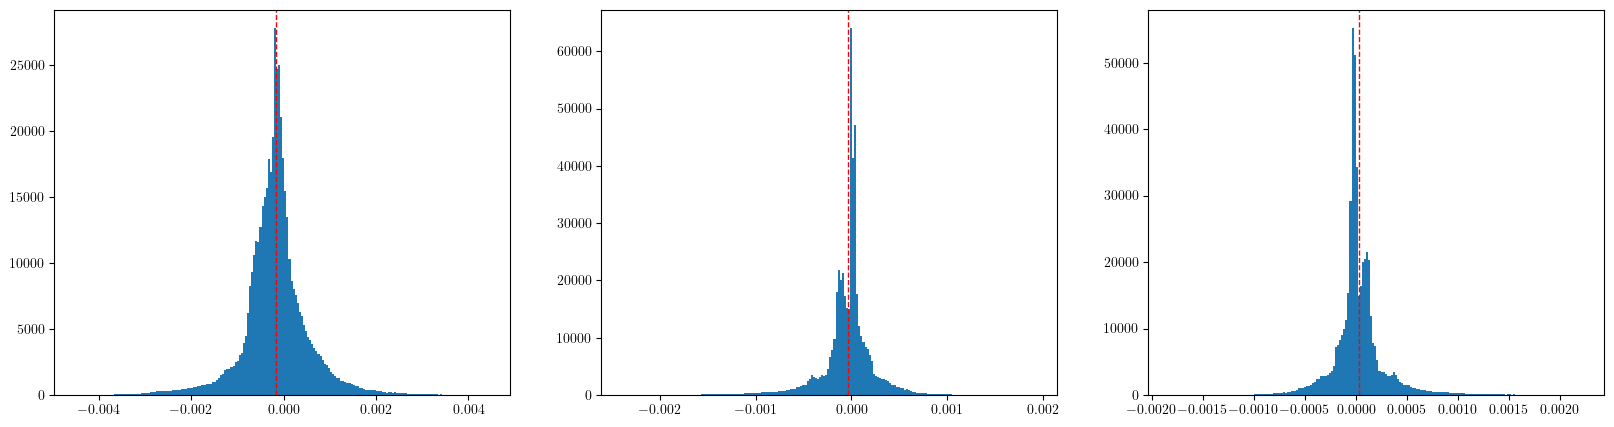

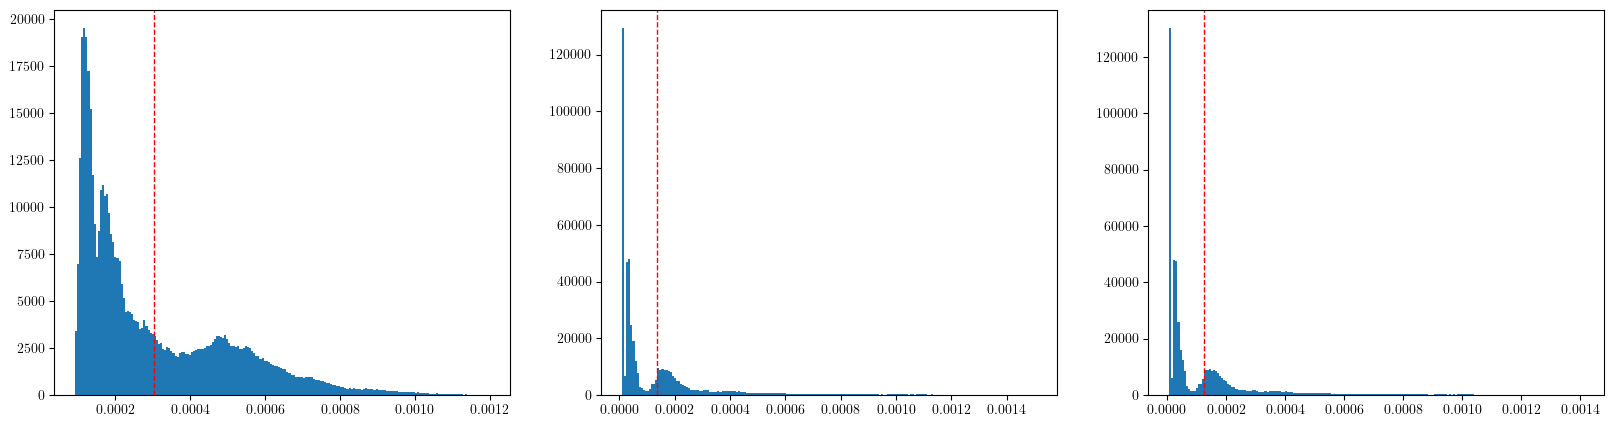

(100, 3)


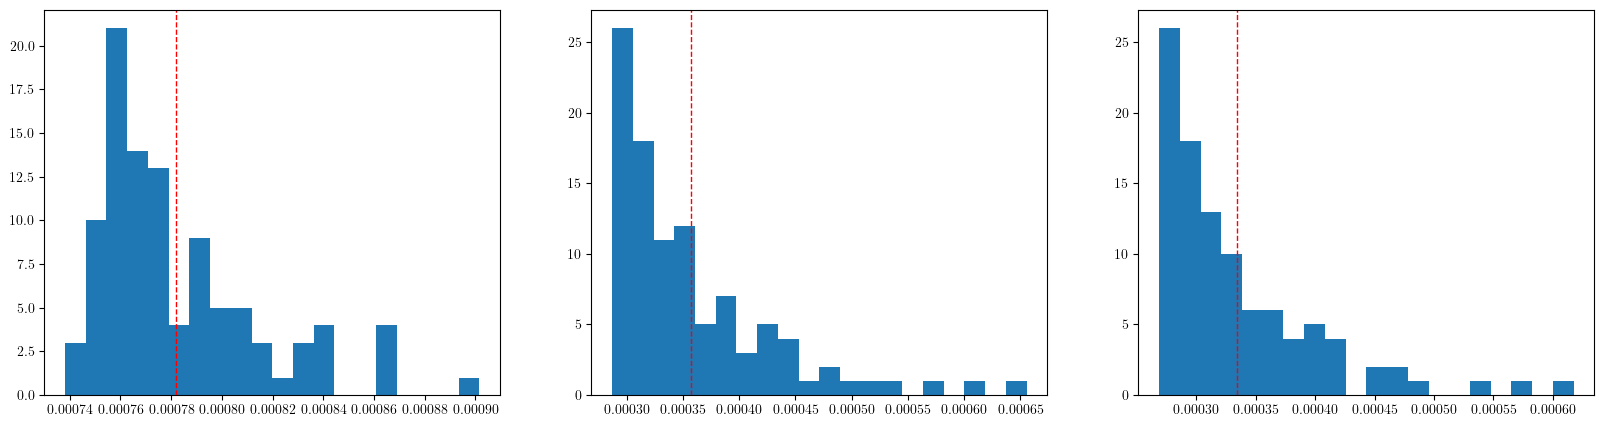

In [10]:
mean_resid = pred_mean - target
resid = pred - target

pred_std = np.std(pred, axis=0)
resid_std = np.std(resid, axis=0)
resid_mean = np.mean(resid, axis=0)
mean_resid_std = np.std(mean_resid, axis=0)
pred_resid_std = np.std(resid, axis=1)

print(f"Obs Noise: {sig_mean}")
print(f"Mean as Prediction")
print(f"Mean of (mean - y): {np.mean(mean_resid, axis=0)}")
print(f"Mean std of (mean - y): {mean_resid_std}")

print(f"Samples as Predictors")
print(f"Mean Residual: {np.mean(resid, axis=(0,1))}")
print(f"Std of Preds: {np.mean(pred_std, axis=0)}")
print(f"Sharpness: {np.std(resid_std, axis=0)}")

print(f"Individual Predictors")
print(f"Mean Residual of Predictors: {np.mean(resid_mean, axis=0)}")
print(f"Std of Residuals {np.std(resid, axis=1).mean(0)} ")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(mean_resid[:, 0], bins=200)
ax[1].hist(mean_resid[:, 1], bins=200)
ax[2].hist(mean_resid[:, 2], bins=200)

ax[0].axvline(mean_resid[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(mean_resid[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(mean_resid[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(resid_std[:, 0], bins=200)
ax[1].hist(resid_std[:, 1], bins=200)
ax[2].hist(resid_std[:, 2], bins=200)

ax[0].axvline(resid_std[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(resid_std[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(resid_std[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

print(pred_resid_std.shape)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(pred_resid_std[:, 0], bins=20)
ax[1].hist(pred_resid_std[:, 1], bins=20)
ax[2].hist(pred_resid_std[:, 2], bins=20)
ax[0].axvline(pred_resid_std[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(pred_resid_std[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(pred_resid_std[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

(100, 5000, 3)
Predicted std: [[0.00079378 0.00046605 0.00043951]]
Training Resid Std: [0.00317477 0.00360067 0.00337529]


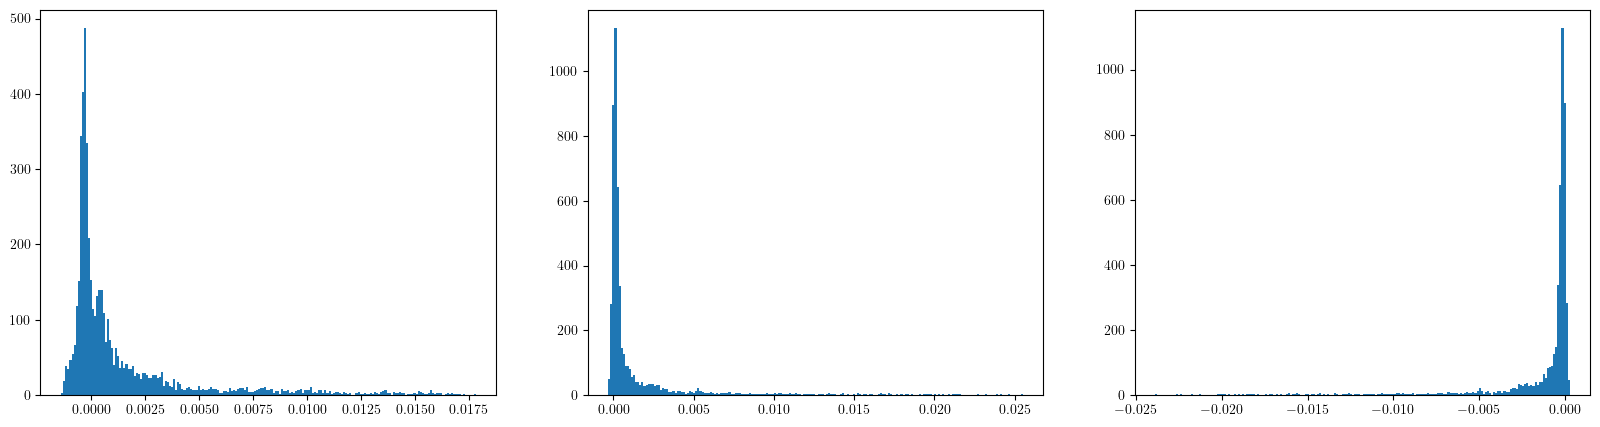

In [16]:
preds_train = predictive(x_train.to(device))[site[0]].cpu().detach().numpy()

for i in range(preds_train.shape[0]):
    preds_train[i] = y_scaler.inverse_transform(preds_train[i])

print(preds_train.shape)

resid = preds_train - gs_train
resid_mean = np.mean(resid, axis=0)
resid_std = np.std(resid, axis=1)

print(f"Predicted std: {sig_mean}")
print(f"Training Resid Std: {resid_std.mean(0)}")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(resid_mean[:, 0], bins=200)
ax[1].hist(resid_mean[:, 1], bins=200)
ax[2].hist(resid_mean[:, 2], bins=200)

plt.show()